# Introduction to swyft-lightning

In this notebook, we will go through the basic steps of performing parameter inference with Swyft.

## Setup

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
N = 10000  # Number of samples
z = np.random.randn(N, 3)
x = z + np.random.randn(N, 3)*0.02 + np.random.rand(N, 1)*0.1
x, z = swyft.to_numpy32(x, z)  # Convenience function to convert to single precision

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [4]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [33]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1), (0, 2))
        self.logratios = swyft.LogRatioEstimator_Ndim(num_features = 3, marginals = marginals, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [34]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [35]:
dl_train = samples[:-500].get_dataloader(batch_size = 64, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 64)

In [36]:
network = Network()

In [37]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_Ndim | 35.2 K
-----------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)


Epoch 0:  95%|█████████▍| 149/157 [00:01<00:00, 98.46it/s, loss=-2.63, v_num=9927147]
Validating: 0it [00:00, ?it/s]
Epoch 1:  96%|█████████▌| 150/157 [00:01<00:00, 99.33it/s, loss=-2.64, v_num=9927147, val_loss=-2.58] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  96%|█████████▌| 150/157 [00:01<00:00, 99.59it/s, loss=-2.69, v_num=9927147, val_loss=-2.63] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  96%|█████████▌| 150/157 [00:01<00:00, 98.83it/s, loss=-2.68, v_num=9927147, val_loss=-2.60] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  96%|█████████▌| 150/157 [00:01<00:00, 98.18it/s, loss=-2.7, v_num=9927147, val_loss=-2.66]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  96%|█████████▌| 150/157 [00:01<00:00, 99.88it/s, loss=-2.68, v_num=9927147, val_loss=-2.66]
Validating: 0it [00:00, ?it/s]
Epoch 6:  96%|█████████▌| 150/157 [00:01<00:00, 99.64it/s, loss=-2.68, v_num=9927147, val_loss=-2.64] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  96%|█████████▌| 150/157 [00:01<00:00, 99.44it/s, loss=-2.7, v_num=9927

## Inference

We assume that we measure the values $x=0.2$.

In [26]:
x0 = 0.2

We first generate a large number of prior samples.

In [27]:
prior_samples = swyft.Samples(dict(z = swyft.to_numpy32(np.random.randn(100000, 3))))

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [28]:
A = swyft.Sample(x = torch.tensor([x0, x0, x0]))
B = prior_samples.get_dataloader(batch_size = 1024)

In [29]:
predictions = trainer.infer(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 149it [00:00, ?it/s]


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

In [30]:
post_samples = predictions.sample(1_000_000)[:,0].numpy()
parname = predictions.parnames
print(parname)

[['z[0]' 'z[1]']
 ['z[0]' 'z[2]']]


Text(0, 0.5, 'z[1]')

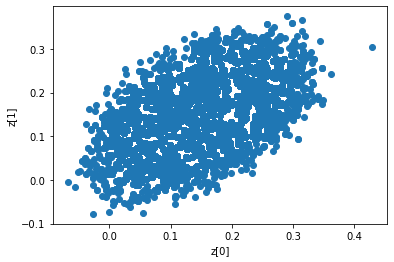

In [31]:
plt.scatter(post_samples[:,0], post_samples[:,1])
plt.xlabel(parname[0,0])
plt.ylabel(parname[0,1])